<a href="https://colab.research.google.com/github/Bone-Age-Maisha/Bone_imp_1/blob/main/only_SE_atlas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("hi")

hi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import cv2
import os
import pandas as pd



In [4]:
import pandas as pd
train_dir = '/content/drive/MyDrive/hand_atlas/image'
df = pd.read_csv('/content/drive/MyDrive/hand_atlas/data.csv')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
X_train = []
y_age = []
y_gender = []

#df = pd.read_csv('/raid/chenchao/code/BoneAge/BoneAge/data/Training.csv')
a = df.values
m = a.shape[0]

path = train_dir
k = 0
print ('Loading data set...')
k=1
for i in os.listdir(path):
  #print(i)
  if(i=="3131.jpg" or i=="4520.jpg" or i=="3187.jpg"):
    continue
  y_age.append(df.boneage[df.id == int(i[:-4])].tolist()[0])
  y_gender.append(df.gender[df.id == int(i[:-4])].tolist()[0])
  #print(i)
  img_path = path + "/"+i
  img = cv2.imread(img_path)
  #print(img.shape)
  #print (img_path)
  img = cv2.imread(img_path)
    #print (img_path)
    #if(img is not None):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(300,300))
  x = np.asarray(img, dtype=np.uint8)
  X_train.append(x)
  k=k+1

Loading data set...


In [6]:
!pip install visualization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 669 kB 29.2 MB/s 
     |████████████████████████████████| 1.2 MB 59.6 MB/s 
     |████████████████████████████████| 116 kB 71.7 MB/s 
     |████████████████████████████████| 132 kB 54.7 MB/s 
     |████████████████████████████████| 109 kB 69.8 MB/s 
     |████████████████████████████████| 978 kB 60.7 MB/s 
     |████████████████████████████████| 964 kB 50.6 MB/s 
     |████████████████████████████████| 2.2 MB 48.5 MB/s 
     |████████████████████████████████| 555 kB 69.0 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
     |████████████████████████████████| 107 kB 74.3 MB/s 
     |████████████████████████████████| 1.0 MB 55.7 MB/s 
     |████████████████████████████████| 1.1 MB 65.5 MB/s 
     |████████████████████████████████| 104 kB 75.2 MB/s 
     |████████████████████████████████| 212 kB 78.5 MB/s 
  Created wheel for PyOpenGL: fil

In [7]:
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing import image
import os

def softlabel(label,num_class):
    softlabel=np.zeros((len(label),num_class))
    ratio = 1.0/50
    for i in range(len(label)):
        for j in range(num_class):
            softlabel[i,j]=1.0 - ratio*np.abs(j-label[i])
    softlabel = np.maximum(softlabel,0)
    return softlabel


def ShowAttentionV1(model,image_path):
    file_list = os.listdir(image_path)
    file_list.sort()
    for filename in file_list:
        print (filename)
        filepath=image_path+filename
        image=load_image(filepath)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        layer=K.function([model.layers[0].input],[model.layers[196].output])
        FeatureMap=layer([image,gender])[0]
        print (FeatureMap.shape)
        FeatureMap = np.squeeze(FeatureMap, axis=0)
        FeatureMap = np.abs(FeatureMap)
        heatmap = np.mean(FeatureMap,axis=2)
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def GAPAttention(model,weights,image_path):
    file_list = os.listdir(train_dir)
    file_list.sort()
    for filename in file_list:
        filepath=image_path+filename
        print (filepath)
        image=load_image(filepath)
        print("gpa")
        print(image.shape)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        print("ok")
        layer=K.function([model.layers[0].input],[model.layers[1].get_output_at(-1),model.layers[-1].output])
        print("ok_1")
        GAP,prediction=layer([image])
        print("ok_2")
        GAP=np.squeeze(GAP,axis=0)
        print("ok_3")
        print (GAP.shape)
        print("ok_4")
        index = np.argmax(prediction)
        print("ok_5")
        print (index)
       # weight = weights[:,index]
        weight =np.mean(weights[:,index-5:index+5],axis=1)
        heatmap = np.zeros((GAP.shape[0],GAP.shape[1]))
        for k in range(GAP.shape[2]):
            heatmap = heatmap + weight[k]*GAP[:,:,k]
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        print (heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def SaveImg(filename,filepath,heatmap):
    img = cv2.imread(filepath)
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
    AttentionImg =0.5* heatmap + img
    cv2.imwrite('/content/heat'+filename,heatmap)
    cv2.imwrite('/content/attention'+filename,AttentionImg)


def load_image(path):
    img = cv2.imread(path)
    print(img.shape)
    img = cv2.resize(img,(300,300))
    print(img.shape)
    x = np.asarray(img, dtype=np.float32)
   # img = image.load_img(path, target_size=(448, 448))
   # print (img.shape)
   # x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def TestMAE(model,test_data,test_label,test_gender):
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[3].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    predictions = np.array(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE
    
def DataAugment(x_train):
    x_train_Aug = np.zeros(x_train.shape)
    for i in range(x_train.shape[0]):
        for j in range(3):
            img = x_train[i,:,:,j]
            img = RandomMask(img)
            img = RandomMask(img)
            if np.random.random()>-1:
                x_train_Aug[i,:,:,j]=img 
            else:
                x_train_Aug[i,:,:,j]=x_train[i,:,:,j]
    return x_train_Aug


def RandomMask(img):
    m,n=img.shape
    m=int(m/6)
    n=int(n/6)
    i,j = np.random.randint(0,6,2)
    img[i*m:(i+1)*m,j*n:(j+1)*n]=np.random.random()
    return img

In [8]:
y = np.asarray(y_age)
gender = np.asarray(y_gender)
x=np.asarray(X_train, dtype=np.float32)
x=x/255
gender =2*( gender-0.5)
x_final = []
y_final = []
gender_final = []

# Shuffle images and split into train, validation and test sets
#random_no = np.random.choice(x.shape[0], size=x.shape[0], replace=False)
random_no = np.arange(x.shape[0])
#print(random_no)
np.random.seed(42)
np.random.shuffle(random_no)
for i in random_no:
    x_final.append(x[i,:,:,:])
    y_final.append(y[i])
    gender_final.append(gender[i])

x_final = np.asarray(x_final)
y_final = np.asarray(y_final)
gender_final = np.asarray(gender_final)
print (y_final[:50])
print (gender_final[:50])
k = 50 # Decides split count
x_test = x_final[:k,:,:,:]
y_test = y_final[:k]
gender_test = gender_final[:k]
x_valid = x_final[k:2*k,:,:,:]
y_valid = y_final[k:2*k]
gender_valid = gender_final[k:2*k]
x_train = x_final[2*k:,:,:,:]
y_train = y_final[2*k:]
gender_train = gender_final[2*k:]

## 
#y_test = keras.utils.to_categorical(y_test,240)
#y_train = keras.utils.to_categorical(y_train,240)
#y_valid = keras.utils.to_categorical(y_valid,240)



print ('x_train shape:'+ str(x_train.shape))
print ('y_train shape:'+ str(y_train.shape))
print ('gender_train shape:'+ str(gender_train.shape))
print ('x_valid shape:'+ str(x_valid.shape))
print ('y_valid shape:'+ str(y_valid.shape))
print ('gender_valid shape:' + str(gender_valid.shape))
print ('x_test shape:'+ str(x_test.shape))
print ('y_test shape:'+ str(y_test.shape))

[ 69.63 140.4  178.9   91.27 215.6  163.1   41.52  94.82 133.2   61.25
 112.4  126.1   98.04 174.5  190.1   94.59  75.88 132.6  157.2   41.95
  75.42  71.84 169.6  153.3  101.1   67.27 118.8  197.5  139.4  189.5
 180.8  175.9  166.4  175.3   67.86 160.   159.7   99.48 123.2  163.9
 218.5  204.7  223.4  206.2  122.4  192.   105.6   84.59 154.8  211.8 ]
[-1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.
  1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
  1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.]
x_train shape:(1286, 300, 300, 3)
y_train shape:(1286,)
gender_train shape:(1286,)
x_valid shape:(50, 300, 300, 3)
y_valid shape:(50,)
gender_valid shape:(50,)
x_test shape:(50, 300, 300, 3)
y_test shape:(50,)


In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda, Multiply,Conv2D
from keras import backend as K
import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras

batch_size = 16
epochs = 30


In [10]:
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(16)(input_gender)
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,2048))(sq)
sq = keras.layers.Dense(units=2048,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))

x = keras.layers.MaxPooling2D(pool_size=(4,4))(net)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
prediction = Dense(1)(f)

model = Model(inputs=[input,input_gender], outputs=prediction)
for i,layer in enumerate(model.layers):
    print (i,layer.name)


Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_invsq_atlas.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=30)
#model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=4,epochs=30,verbose=1,validation_data=([x_valid,gender_valid],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

87910968/87910968 [==============================] - 5s 0us/step
(None, 2048)
(None, 4, 4, 2048)
(None, 1, 1, 2048)
(None, 2064)
0 input1
1 inception_v3
2 global_average_pooling2d
3 reshape
4 dense_1
5 multiply
6 add
7 batch_normalization_94
8 activation_94
9 block_1
10 max_pooling2d_4
11 input2
12 flatten
13 dense
14 concatenate_2
15 dense_2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, None, None,   21802784    ['input1[0][0]']                 
                                2048)         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
322/322 [==============================] - 50s 98ms/step - loss: 37.4404 - MAE: 37.4404 - val_loss: 131.2896 - val_MAE: 131.2896
Epoch 2/30
322/322 [==============================] - 27s 85ms/step - loss: 22.1012 - MAE: 22.1012 - val_loss: 18.0874 - val_MAE: 18.0874
Epoch 3/30
322/322 [==============================] - 27s 83ms/step - loss: 22.4988 - MAE: 22.4988 - val_loss: 19.0321 - val_MAE: 19.0321
Epoch 4/30
322/322 [==============================] - 30s 92ms/step - loss: 18.8750 - MAE: 18.8750 - val_loss: 41.1009 - val_MAE: 41.1009
Epoch 5/30
322/322 [==============================] - 28s 88ms/step - loss: 17.3695 - MAE: 17.3695 - val_loss: 13.1455 - val_MAE: 13.1455
Epoch 6/30
322/322 [==============================] - 27s 84ms/step - loss: 15.5197 - MAE: 15.5197 - val_loss: 15.2290 - val_MAE: 15.2290
Epoch 7/30
322/322 [==============================] - 28s 88ms/step - loss: 13.9876 - MAE: 13.9876 - val_loss: 14.9475 - val_MAE: 14.9475
Epoch 8/30
322/322 [============

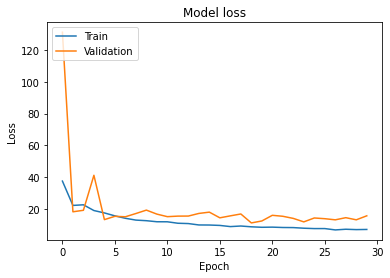

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(16)(input_gender)
print (K.int_shape(output))
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,1536))(sq)
sq = keras.layers.Dense(units=1536,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))

x = keras.layers.MaxPooling2D(pool_size=(4,4))(net)
print (K.int_shape(x))
x=Flatten()(x)
f= keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
prediction = Dense(1)(f)

model = Model(inputs=[input,input_gender], outputs=prediction)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_invressq_atlas.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=30)
#model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=4,epochs=30,verbose=1,validation_data=([x_valid,gender_valid],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 8, 8, 1536)
(None, 1536)
(None, 4, 4, 1536)
(None, 1, 1, 1536)
(None, 1552)
0 input1
1 inception_resnet_v2
2 global_average_pooling2d_2
3 reshape_2
4 dense_5
5 multiply_1
6 add_1
7 batch_normalization_501
8 activation_501
9 block_1
10 max_pooling2d_13
11 input2
12 flatten_1
13 dense_4
14 concatenate_3
15 dense_6
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v2 (Functiona  (None, None, None,   54336736   ['input1[0][0]']                 
 l)                             1536)                               

Epoch 1/30
322/322 [==============================] - 89s 211ms/step - loss: 33.4780 - MAE: 33.4780 - val_loss: 23.7434 - val_MAE: 23.7434
Epoch 2/30
322/322 [==============================] - 63s 196ms/step - loss: 18.7755 - MAE: 18.7755 - val_loss: 22.0202 - val_MAE: 22.0202
Epoch 3/30
322/322 [==============================] - 63s 194ms/step - loss: 16.3724 - MAE: 16.3724 - val_loss: 18.6031 - val_MAE: 18.6031
Epoch 4/30
322/322 [==============================] - 63s 195ms/step - loss: 14.7177 - MAE: 14.7177 - val_loss: 17.1390 - val_MAE: 17.1390
Epoch 5/30
322/322 [==============================] - 62s 194ms/step - loss: 13.3308 - MAE: 13.3308 - val_loss: 11.5876 - val_MAE: 11.5876
Epoch 6/30
322/322 [==============================] - 63s 194ms/step - loss: 11.6310 - MAE: 11.6310 - val_loss: 11.0234 - val_MAE: 11.0234
Epoch 7/30
322/322 [==============================] - 62s 193ms/step - loss: 10.9172 - MAE: 10.9172 - val_loss: 12.3509 - val_MAE: 12.3509
Epoch 8/30
322/322 [=======

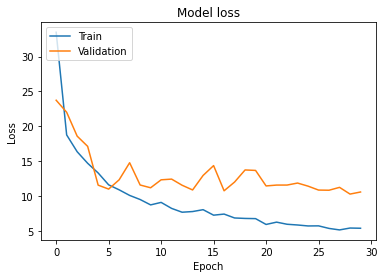

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(16)(input_gender)
print (K.int_shape(output))
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,1920))(sq)
sq = keras.layers.Dense(units=1920,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))

x = keras.layers.MaxPooling2D(pool_size=(4,4))(net)
print (K.int_shape(x))
x=Flatten()(x)
f= keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
prediction = Dense(1)(f)

model = Model(inputs=[input,input_gender], outputs=prediction)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_denssq_atlas.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=30)
#model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=4,epochs=30,verbose=1,validation_data=([x_valid,gender_valid],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

(None, 9, 9, 1920)
(None, 1920)
(None, 4, 4, 1920)
(None, 1, 1, 1920)
(None, 1936)
0 input1
1 densenet201
2 global_average_pooling2d_4
3 reshape_4
4 dense_9
5 multiply_2
6 add_2
7 batch_normalization_502
8 activation_502
9 block_1
10 max_pooling2d_14
11 input2
12 flatten_2
13 dense_8
14 concatenate_4
15 dense_10
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, None, None,   18321984    ['input1[0][0]']                 
                                1920)                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
322/322 [==============================] - 89s 189ms/step - loss: 33.0433 - MAE: 33.0433 - val_loss: 66.5627 - val_MAE: 66.5627
Epoch 2/30
322/322 [==============================] - 49s 153ms/step - loss: 21.3046 - MAE: 21.3046 - val_loss: 16.7230 - val_MAE: 16.7230
Epoch 3/30
322/322 [==============================] - 49s 152ms/step - loss: 16.9354 - MAE: 16.9354 - val_loss: 22.0362 - val_MAE: 22.0362
Epoch 4/30
322/322 [==============================] - 49s 152ms/step - loss: 15.2673 - MAE: 15.2673 - val_loss: 33.6774 - val_MAE: 33.6774
Epoch 5/30
322/322 [==============================] - 49s 153ms/step - loss: 14.0634 - MAE: 14.0634 - val_loss: 19.1398 - val_MAE: 19.1398
Epoch 6/30
322/322 [==============================] - 49s 152ms/step - loss: 13.3867 - MAE: 13.3867 - val_loss: 14.7721 - val_MAE: 14.7721
Epoch 7/30
322/322 [==============================] - 49s 152ms/step - loss: 12.9325 - MAE: 12.9325 - val_loss: 13.4841 - val_MAE: 13.4841
Epoch 8/30
322/322 [=======

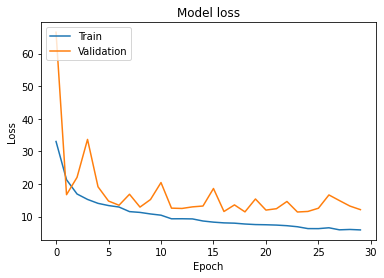

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101

base_model = ResNet101(weights='imagenet', include_top=False)
input = Input(shape=(300,300,3),name='input1')
input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
gender_embedding=Dense(16)(input_gender)
print (K.int_shape(output))
sq = keras.layers.GlobalAveragePooling2D()(output)
print (K.int_shape(sq))
sq = keras.layers.Reshape((1,1,2048))(sq)
sq = keras.layers.Dense(units=2048,activation="sigmoid")(sq)
block = keras.layers.multiply([output,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([output,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)
print (K.int_shape(net))

x = keras.layers.MaxPooling2D(pool_size=(4,4))(net)
print (K.int_shape(x))
x=Flatten()(x)
f= keras.layers.Concatenate(axis=1)([x,gender_embedding])
print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
prediction = Dense(1)(f)

model = Model(inputs=[input,input_gender], outputs=prediction)
for i,layer in enumerate(model.layers):
    print (i,layer.name)

Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
model.summary()

checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights_res101sq_atlas.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=30)
#model.fit_generator(DataGen.flow([x_train,gender_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=50,verbose=1,validation_data=([x_valid,gender_valid,agev],y_valid))
history=model.fit([x_train,gender_train],y_train,batch_size=4,epochs=30,verbose=1,validation_data=([x_valid,gender_valid],y_valid),callbacks = [checkpoint])
score = model.evaluate([x_test,gender_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

171446536/171446536 [==============================] - 9s 0us/step
(None, 10, 10, 2048)
(None, 2048)
(None, 5, 5, 2048)
(None, 1, 1, 2048)
(None, 2064)
0 input1
1 resnet101
2 global_average_pooling2d_5
3 reshape_5
4 dense_12
5 multiply_3
6 add_3
7 batch_normalization_503
8 activation_503
9 block_1
10 max_pooling2d_15
11 input2
12 flatten_3
13 dense_11
14 concatenate_5
15 dense_13
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet101 (Functional)         (None, None, None,   42658176    ['input1[0][0]']                 
      

Epoch 1/30
322/322 [==============================] - 75s 191ms/step - loss: 31.4706 - MAE: 31.4706 - val_loss: 140.5635 - val_MAE: 140.5635
Epoch 2/30
322/322 [==============================] - 57s 178ms/step - loss: 23.7044 - MAE: 23.7044 - val_loss: 141.8695 - val_MAE: 141.8695
Epoch 3/30
322/322 [==============================] - 57s 179ms/step - loss: 21.5799 - MAE: 21.5799 - val_loss: 58.8277 - val_MAE: 58.8277
Epoch 4/30
322/322 [==============================] - 57s 177ms/step - loss: 19.3207 - MAE: 19.3207 - val_loss: 39.7645 - val_MAE: 39.7645
Epoch 5/30
322/322 [==============================] - 57s 176ms/step - loss: 17.0272 - MAE: 17.0272 - val_loss: 34.0415 - val_MAE: 34.0415
Epoch 6/30
322/322 [==============================] - 57s 177ms/step - loss: 15.4906 - MAE: 15.4906 - val_loss: 18.4155 - val_MAE: 18.4155
Epoch 7/30
322/322 [==============================] - 57s 177ms/step - loss: 14.8701 - MAE: 14.8701 - val_loss: 44.9791 - val_MAE: 44.9791
Epoch 8/30
322/322 [===

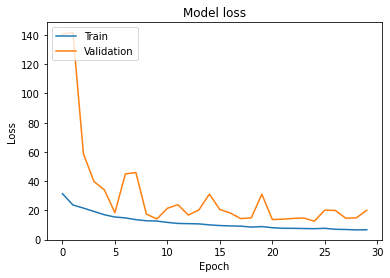

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()